In [1]:
from IPython.display import HTML

!pip install pyspark==2.4.5
HTML("<h3 style='color:green;'>Pyspark installed</h3>")

In [2]:
!pip install tensorflow==2.2.0rc0
HTML("<h3 style='color:green;'>TensorFlow installed</h3>")

In [3]:
#mandatory

#check Pyspark is installe
from IPython.display import HTML
h = HTML("Pyspark OK")
try:
    from pyspark import SparkContext, SparkConf
except ModuleNotFoundError as e:
    h = HTML("<h3 style='color:red;'>!!!!! Please install pyspark - run previous cell !!!!!</h3>")
h    

In [4]:
#mandatory
h = HTML("SparkSession OK")
try:
    from pyspark.sql import SparkSession
except ImportError as e:
    h = HTML("<h3 style='color:red;'>!!!!! Please restart your kernel after installing Apache Spark !!!!!</h3>")

h    

In [5]:
#mandatory
h = HTML("SparkContext OK")

try:
    sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

    spark = SparkSession \
        .builder \
        .getOrCreate()
except Error as e:
    h = HTML("<h3 style='color:red;'>!!!!! SparkContext or SparkSession creation error !!!!!</h3>")

h

In [6]:
import tensorflow as tf

h = HTML("TensorFlow version OK")

if not tf.__version__ == '2.2.0-rc0':
    print(tf.__version__)
    h = HTML("<h3 style='color:red;'>Please upgrade to TensorFlow 2.2.0-rc0, or restart your Kernel (Kernel->Restart & Clear Output)</h3>")

h    

### Get Data From GitHub repository

In [7]:
!wget https://raw.githubusercontent.com/tarasryb/PJM-Energy-Load-Profile/master/data/pjm_AEP_normalized.csv

--2020-07-13 19:33:37--  https://raw.githubusercontent.com/tarasryb/PJM-Energy-Load-Profile/master/data/pjm_AEP_normalized.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914906 (893K) [text/plain]
Saving to: ‘pjm_AEP_normalized.csv.1’

100%[======================================>] 914,906     --.-K/s   in 0.03s   

2020-07-13 19:33:37 (25.7 MB/s) - ‘pjm_AEP_normalized.csv.1’ saved [914906/914906]



### Check the data file was downloaded successfully

In [10]:
res = !ls -l

h = HTML('<h3 style="color:red">Can not download pjm_AEP_normalized.csv file from GitHub</h3>')
for st in res:
    i = st.find('pjm_AEP_normalized.csv')
    if i > 0:
        h = HTML('<h3 style="color:green">pjm_AEP_normalized.csv file downloaded successfuly</h3>')

h

### Load CSV file into PySpark Dataframe

In [11]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col

#read csv to Pyspark Dataframe
df = spark.read.format("csv").option("header", "true").load("pjm_AEP_normalized.csv")

In [50]:
df.printSchema()

root
 |-- day: string (nullable = true)
 |-- ts: string (nullable = true)
 |-- h_0: string (nullable = true)
 |-- h_1: string (nullable = true)
 |-- h_2: string (nullable = true)
 |-- h_3: string (nullable = true)
 |-- h_4: string (nullable = true)
 |-- h_5: string (nullable = true)
 |-- h_6: string (nullable = true)
 |-- h_7: string (nullable = true)
 |-- h_8: string (nullable = true)
 |-- h_9: string (nullable = true)
 |-- h_10: string (nullable = true)
 |-- h_11: string (nullable = true)
 |-- h_12: string (nullable = true)
 |-- h_13: string (nullable = true)
 |-- h_14: string (nullable = true)
 |-- h_15: string (nullable = true)
 |-- h_16: string (nullable = true)
 |-- h_17: string (nullable = true)
 |-- h_18: string (nullable = true)
 |-- h_19: string (nullable = true)
 |-- h_20: string (nullable = true)
 |-- h_21: string (nullable = true)
 |-- h_22: string (nullable = true)
 |-- h_23: string (nullable = true)



In [51]:
#cast all columns except Datetime to Double
colList = df.columns
colList.remove('day')
colList.remove('ts')
    
for column in colList:
    df = df.withColumn(column, col(column).cast("double"))
    
df.printSchema()
df.count()
#df.toPandas()

root
 |-- day: string (nullable = true)
 |-- ts: string (nullable = true)
 |-- h_0: double (nullable = true)
 |-- h_1: double (nullable = true)
 |-- h_2: double (nullable = true)
 |-- h_3: double (nullable = true)
 |-- h_4: double (nullable = true)
 |-- h_5: double (nullable = true)
 |-- h_6: double (nullable = true)
 |-- h_7: double (nullable = true)
 |-- h_8: double (nullable = true)
 |-- h_9: double (nullable = true)
 |-- h_10: double (nullable = true)
 |-- h_11: double (nullable = true)
 |-- h_12: double (nullable = true)
 |-- h_13: double (nullable = true)
 |-- h_14: double (nullable = true)
 |-- h_15: double (nullable = true)
 |-- h_16: double (nullable = true)
 |-- h_17: double (nullable = true)
 |-- h_18: double (nullable = true)
 |-- h_19: double (nullable = true)
 |-- h_20: double (nullable = true)
 |-- h_21: double (nullable = true)
 |-- h_22: double (nullable = true)
 |-- h_23: double (nullable = true)



1877

# Create train data set: extract winter and summer data 

In [52]:
df.createOrReplaceTempView('pjm_AEP_normalized')

In [53]:
winter_data = spark.sql("""
    select *
        from pjm_AEP_normalized 
        where unix_timestamp(day, "yyyy-MM-dd") >= unix_timestamp("2015-12-01", "yyyy-MM-dd")AND
              unix_timestamp(day, "yyyy-MM-dd") <= unix_timestamp("2016-02-28", "yyyy-MM-dd")
        
    """)
print(winter_data.count())

90


In [54]:
summer_data = spark.sql("""
    select *
        from pjm_AEP_normalized 
        where unix_timestamp(day, "yyyy-MM-dd") >= unix_timestamp("2016-06-01", "yyyy-MM-dd")AND
              unix_timestamp(day, "yyyy-MM-dd") <= unix_timestamp("2016-08-29", "yyyy-MM-dd")
        
    """)
print(summer_data.count())

90


In [55]:
import numpy as np

winter_data = np.array(winter_data.select(
    "h_0", "h_1", "h_2", "h_3", "h_4", "h_5", "h_6", "h_7", "h_8", "h_9", "h_10", "h_11",
    "h_12", "h_13", "h_14", "h_15", "h_16", "h_17", "h_18", "h_19", "h_20", "h_21", "h_22", "h_23"    
    ).collect())

summer_data = np.array(summer_data.select(
    "h_0", "h_1", "h_2", "h_3", "h_4", "h_5", "h_6", "h_7", "h_8", "h_9", "h_10", "h_11",
    "h_12", "h_13", "h_14", "h_15", "h_16", "h_17", "h_18", "h_19", "h_20", "h_21", "h_22", "h_23"    
    ).collect())

In [56]:
winter_data.shape


(90, 24)

In [57]:
summer_data.shape

(90, 24)

In [58]:
#???
winter_data.reshape(90, 24)
summer_data.reshape(90, 24)

array([[0.30340414, 0.23288033, 0.17535295, ..., 0.52665259, 0.51233672,
        0.42439636],
       [0.33665391, 0.25201214, 0.20880063, ..., 0.47644808, 0.45573295,
        0.38633065],
       [0.30525135, 0.23829001, 0.19408893, ..., 0.46615649, 0.44656287,
        0.38276818],
       ...,
       [0.42822272, 0.34734134, 0.29337643, ..., 0.57468004, 0.52130888,
        0.45118089],
       [0.36944188, 0.30459163, 0.25214408, ..., 0.58840216, 0.53450323,
        0.44069138],
       [0.36442802, 0.3041958 , 0.2518802 , ..., 0.69527642, 0.62607204,
        0.50672912]])

# Design network

In [59]:
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
from queue import Queue
import pandas as pd
import json
%matplotlib inline

In [60]:
dim = 24
samples = 90

In [61]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        sys.stdout.write(str(logs.get('loss'))+str(', '))
        sys.stdout.flush()
        self.losses.append(logs.get('loss'))
        
lr = LossHistory()

In [62]:
number_of_neurons_layer1 = 24 
number_of_neurons_layer2 = 24 
number_of_neurons_layer3 = 1 
number_of_epochs = 500

In [63]:
# design network
from tensorflow.keras import optimizers
sgd = optimizers.SGD(lr=0.01, clipnorm=1.)

model = Sequential()
model.add(Dense(number_of_neurons_layer1,input_shape=(dim, ), activation='relu'))
model.add(Dense(number_of_neurons_layer2, activation='relu'))
model.add(Dense(number_of_neurons_layer3, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=sgd)

def train(data,label):
    model.fit(data, label, epochs=number_of_epochs, batch_size=72, validation_data=(data, label), verbose=1, shuffle=True,callbacks=[lr]) #validation_data=(data, label)

def score(data):
    return model.predict(data)

### Create labels for data

In [64]:
winter_label = np.repeat(1, 90)
winter_label.shape = (90, 1)
summer_label = np.repeat(0, 90)
summer_label.shape = (90, 1)
both_label = np.vstack((winter_label,summer_label))

train_winter = np.hstack((winter_data,winter_label))
train_summer = np.hstack((summer_data,summer_label))

both_data = np.vstack((winter_data, summer_data))
train_both = np.vstack((train_winter,train_summer))

In [65]:
train_both.shape

(180, 25)

In [66]:
train(both_data, both_label)

Epoch 1/500
3/3 [==============================] - 0s 79ms/step - loss: 0.7341 - val_loss: 0.721541230511665344,
Epoch 2/500
3/3 [==============================] - 0s 16ms/step - loss: 0.7296 - val_loss: 0.718896198010444641,
Epoch 3/500
3/3 [==============================] - 0s 16ms/step - loss: 0.7276 - val_loss: 0.716076113629341125,
Epoch 4/500
3/3 [==============================] - 0s 16ms/step - loss: 0.7228 - val_loss: 0.713128273749351501,
Epoch 5/500
3/3 [==============================] - 0s 17ms/step - loss: 0.7211 - val_loss: 0.710610683822631836,
Epoch 6/500
3/3 [==============================] - 0s 18ms/step - loss: 0.7205 - val_loss: 0.708504639315605164,
Epoch 7/500
3/3 [==============================] - 0s 16ms/step - loss: 0.7153 - val_loss: 0.706352859568595886,
Epoch 8/500
3/3 [==============================] - 0s 16ms/step - loss: 0.7127 - val_loss: 0.704127010226249695,
Epoch 9/500
3/3 [==============================] - 0s 16ms/step - loss: 0.7088 - val_loss: 0.702

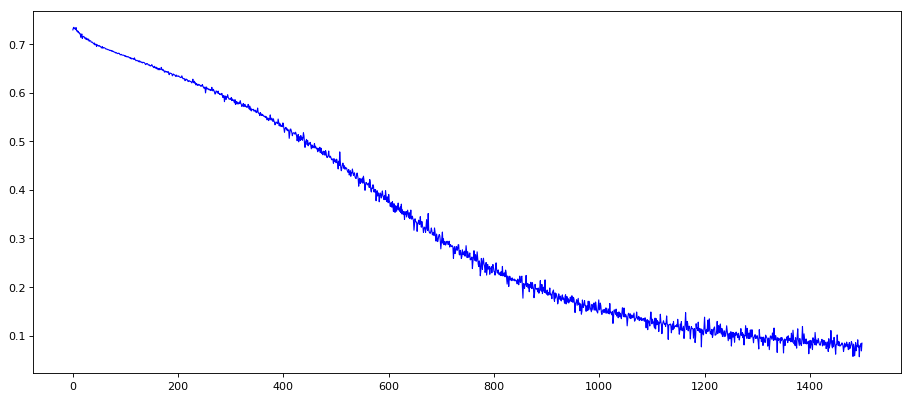

In [67]:
#plot losses
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(lr.losses)
ax.plot(range(0,size), lr.losses, '-', color='blue', animated = True, linewidth=1)

# Evaluate Model

In [69]:
# get validation data for winter 2014-2015
winter_val_data = spark.sql("""
    select *
        from pjm_AEP_normalized 
        where unix_timestamp(day, "yyyy-MM-dd") >= unix_timestamp("2014-12-01", "yyyy-MM-dd")AND
              unix_timestamp(day, "yyyy-MM-dd") <= unix_timestamp("2015-02-28", "yyyy-MM-dd")
        
    """)
print(winter_val_data.count())

90


In [70]:
# get validation data for summer 2015
summer_val_data = spark.sql("""
    select *
        from pjm_AEP_normalized 
        where unix_timestamp(day, "yyyy-MM-dd") >= unix_timestamp("2015-06-01", "yyyy-MM-dd")AND
              unix_timestamp(day, "yyyy-MM-dd") <= unix_timestamp("2015-08-29", "yyyy-MM-dd")
        
    """)
print(summer_val_data.count())

90


In [71]:
winter_val_data = np.array(winter_val_data.select(
    "h_0", "h_1", "h_2", "h_3", "h_4", "h_5", "h_6", "h_7", "h_8", "h_9", "h_10", "h_11",
    "h_12", "h_13", "h_14", "h_15", "h_16", "h_17", "h_18", "h_19", "h_20", "h_21", "h_22", "h_23"    
    ).collect())

summer_val_data = np.array(summer_val_data.select(
    "h_0", "h_1", "h_2", "h_3", "h_4", "h_5", "h_6", "h_7", "h_8", "h_9", "h_10", "h_11",
    "h_12", "h_13", "h_14", "h_15", "h_16", "h_17", "h_18", "h_19", "h_20", "h_21", "h_22", "h_23"    
    ).collect())


In [72]:
val_data = np.vstack((winter_val_data, summer_val_data))

results = model.evaluate(val_data, both_label)
print("test loss, test acc:", results)

6/6 [==============================] - 0s 1ms/step - loss: 0.1116
test loss, test acc: 0.11159682273864746


In [73]:
prediction = model.predict(val_data)
prediction_with_lab= np.hstack((prediction, both_label))

positives = 0
negatives = 0

for item in prediction_with_lab:
    p = item[0] #prediction
    l = item[1] #label
    if l == 1:  #winter label
        if p > 0.5:
            positives += 1
        else:
            negatives += 1

    if l == 0:  #summer label
        if p < 0.5:
            positives += 1
        else:
            negatives += 1
            
            
print(format('total: %d ' % len(prediction_with_lab)))
print(format('positives: %d \nnegatives: %d' % (positives, negatives)))

accuracy = positives / len(prediction_with_lab) * 100

print(format('accuracy: %.2f%%' % accuracy))


total: 180 
positives: 175 
negatives: 5
accuracy: 97.22%


In [74]:
model.predict(summer_val_data)

array([[0.44142964],
       [0.69176227],
       [0.5448546 ],
       [0.15204883],
       [0.07775983],
       [0.28122807],
       [0.07027027],
       [0.20493838],
       [0.14139551],
       [0.02321151],
       [0.01494145],
       [0.04410672],
       [0.03456441],
       [0.0257501 ],
       [0.02161121],
       [0.06694824],
       [0.3134929 ],
       [0.02158344],
       [0.2632087 ],
       [0.18034011],
       [0.0337896 ],
       [0.01274058],
       [0.07102618],
       [0.04263815],
       [0.13794318],
       [0.19827995],
       [0.6174451 ],
       [0.27512196],
       [0.29973117],
       [0.13730034],
       [0.12724212],
       [0.46232998],
       [0.30439618],
       [0.11104044],
       [0.08968866],
       [0.02562091],
       [0.06503949],
       [0.4008288 ],
       [0.1688115 ],
       [0.17842558],
       [0.07641542],
       [0.10109243],
       [0.07306206],
       [0.08503601],
       [0.25150058],
       [0.0960463 ],
       [0.02023935],
       [0.019

In [75]:
from sklearn.metrics import confusion_matrix

y_pred = prediction > 0.5      #clf.predict(X_test)
cm = confusion_matrix(both_label, y_pred)
print(cm)


[[85  5]
 [ 0 90]]


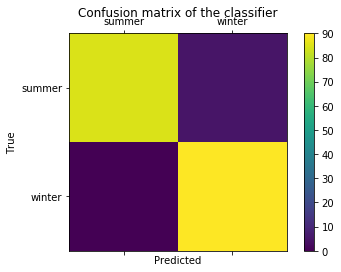

In [76]:
#plot confusion matrix
labels = ['summer', 'winter']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [77]:
#Print classification report
from sklearn.metrics import classification_report

labels = ['summer', 'winter']
print(classification_report(both_label, y_pred, target_names=labels))

              precision    recall  f1-score   support

      summer       1.00      0.94      0.97        90
      winter       0.95      1.00      0.97        90

   micro avg       0.97      0.97      0.97       180
   macro avg       0.97      0.97      0.97       180
weighted avg       0.97      0.97      0.97       180

